<a href="https://colab.research.google.com/github/sydney-ho/Airbnb-Analysis/blob/main/airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix



# EDA

In [162]:
df = pd.read_csv('AB_NYC_2019.csv')

In [163]:
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [164]:
# Remove unnecessary column
df.drop(['id','host_id', 'host_name','last_review', 'name', 'calculated_host_listings_count', 'availability_365'], axis=1, inplace=True)

In [165]:
# Drop rows with no prices:

df['price'].dropna(inplace=True)

In [166]:
# Define null items by columns

# This finds the percentage of null values by column
df.isnull().sum()/len(df)*100

neighbourhood_group     0.000000
neighbourhood           0.000000
latitude                0.000000
longitude               0.000000
room_type               0.000000
price                   0.000000
minimum_nights          0.000000
number_of_reviews       0.000000
reviews_per_month      20.558339
dtype: float64

In [167]:
# Clean data by accounting for null values, repalcing them with necessary values

df['reviews_per_month'].fillna(0, inplace=True)

In [168]:
df['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [169]:
cwd = os.getcwd()
path = cwd + '/final_clean_airbnb.csv'
df.to_csv(path, index=False)

In [132]:
import re

# Clean the Price Column
def clean_price(price):
    if price:
        numeric_price = re.sub("[^0-9.]", "", str(price))
        if numeric_price:
            return float(numeric_price)
    return None

df["price"] = df["price"].apply(clean_price)



In [170]:
# Filter out price values above 1200, denoted as outliers:

df = df[df["price"] <= 1200]

In [171]:
from math import radians, sin, cos, sqrt, atan2

# Add a new variable to track the distance from Times Square

# Define the coordinates of Times Square
ts_lat, ts_lon = 40.7589, -73.9851

# Define a function to calculate the distance between two coordinates using the Haversine formula
def distance(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the earth in km
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    a = sin(dLat/2) * sin(dLat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dLon/2) * sin(dLon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c
    return d

# Apply the distance function to calculate the distance between each property and Times Square
df['dist_from_manhattan'] = df.apply(lambda row: distance(row['latitude'], row['longitude'], ts_lat, ts_lon), axis=1)


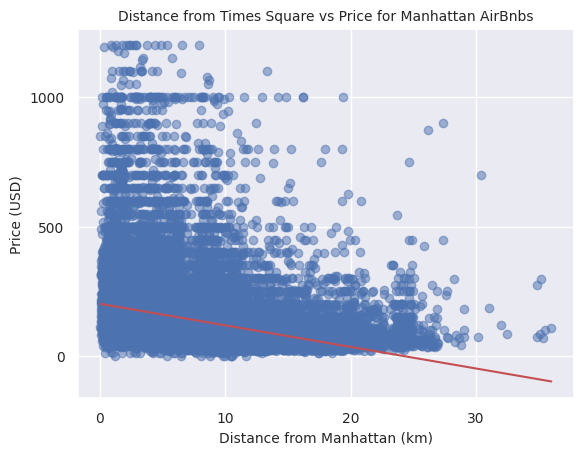

In [172]:
from scipy.stats import linregress

# Create a scatter plot of distance from Manhattan vs price
plt.scatter(df['dist_from_manhattan'], df['price'], alpha=0.5)
plt.title('Distance from Times Square vs Price for Manhattan AirBnbs', fontsize=10)
plt.xlabel('Distance from Manhattan (km)', fontsize=10)
plt.ylabel('Price (USD)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
xticks_vals = np.linspace(0, 40, 5) # 0 to 40 in 4 equal increments
xticks_labels = [f'{x:.0f}' for x in xticks_vals]
plt.xticks(xticks_vals, xticks_labels)

# Calculate the slope and intercept of the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(df['dist_from_manhattan'], df['price'])
x = np.array([df['dist_from_manhattan'].min(), df['dist_from_manhattan'].max()])
y = slope * x + intercept

# Plot the regression line over the scatter plot
plt.plot(x, y, color='r')

plt.show()

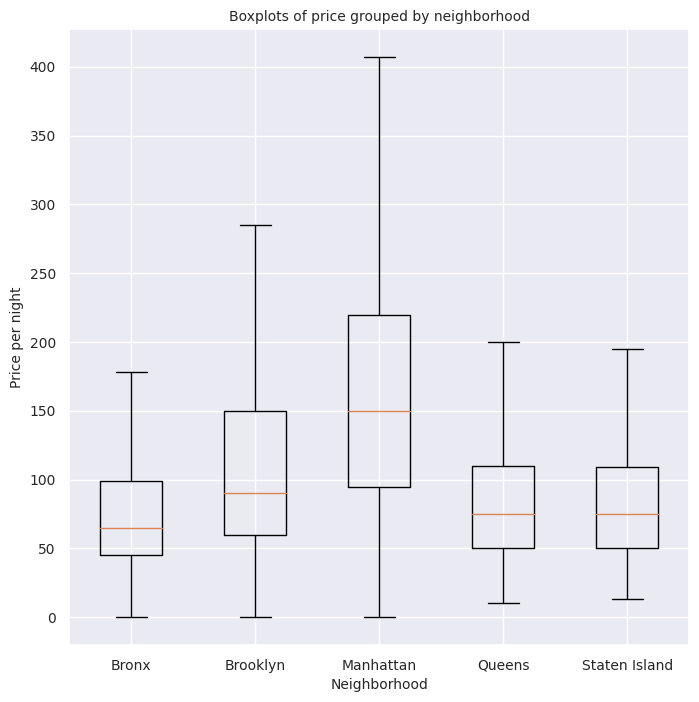

In [173]:
neighbourhood_group_price = df.groupby('neighbourhood_group').price

fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot([neighbourhood_group_price.get_group('Bronx'),
            neighbourhood_group_price.get_group('Brooklyn'),
            neighbourhood_group_price.get_group('Manhattan'),
            neighbourhood_group_price.get_group('Queens'),
            neighbourhood_group_price.get_group('Staten Island')],
            labels=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],showfliers=False)

ax.set_xlabel("Neighborhood", fontsize=10)
ax.set_ylabel("Price per night", fontsize=10)
ax.set_title("Boxplots of price grouped by neighborhood", fontsize=10)
ax.tick_params(axis='both', labelsize=10)

plt.show()

In [137]:
neighbourhood_group_price.describe()

count        mean         std   min   25%    50%  \
neighbourhood_group                                                       
Bronx                 1089.0   85.361800   77.761144  10.0  45.0   65.0   
Brooklyn             20050.0  118.303890   96.670552  10.0  60.0   90.0   
Manhattan            21526.0  180.638066  139.723956  10.0  95.0  150.0   
Queens                5656.0   95.008310   74.527596  10.0  50.0   75.0   
Staten Island          371.0   98.584906   96.138752  13.0  50.0   75.0   

                       75%     max  
neighbourhood_group                 
Bronx                 99.0  1000.0  
Brooklyn             150.0  1200.0  
Manhattan            220.0  1200.0  
Queens               110.0  1000.0  
Staten Island        109.0  1000.0

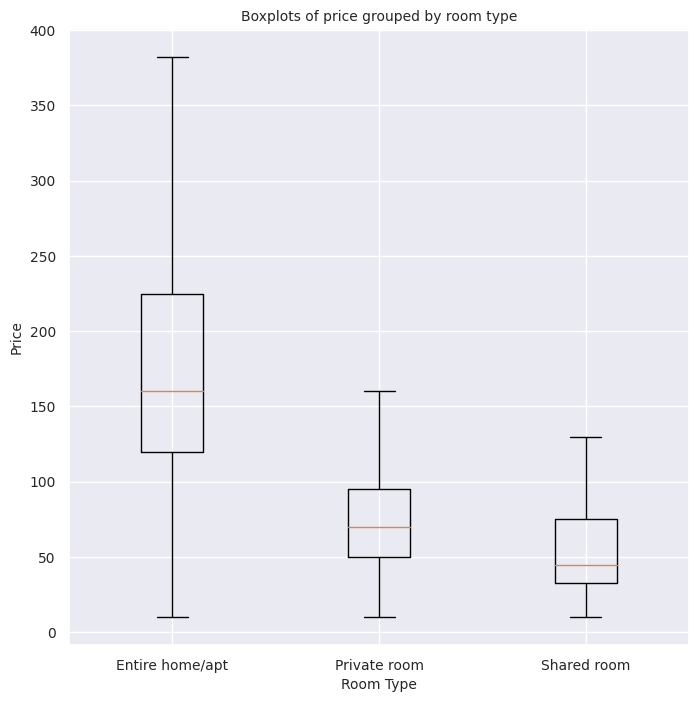

In [138]:
# Create boxplots grouped by room type

room_type_grouped_price = df.groupby('room_type').price.mean()

fig, ax = plt.subplots(figsize=(8, 8))
boxplot_data = [df[df['room_type'] == room_type]['price'] for room_type in room_type_grouped_price.index]
ax.boxplot(boxplot_data, labels=room_type_grouped_price.index, showfliers=False)

ax.set_xlabel("Room Type", fontsize=10)
ax.set_ylabel("Price", fontsize=10)
ax.set_title("Boxplots of price grouped by room type", fontsize=10)
ax.tick_params(axis='both', labelsize=10)

plt.show()

In [139]:
df.groupby('room_type').price.describe()

count        mean         std   min    25%    50%    75%  \
room_type                                                                     
Entire home/apt  25259.0  196.212914  131.844884  10.0  120.0  160.0  225.0   
Private room     22277.0   84.969655   70.064162  10.0   50.0   70.0   95.0   
Shared room       1156.0   67.731834   81.076816  10.0   33.0   45.0   75.0   

                    max  
room_type                
Entire home/apt  1200.0  
Private room     1200.0  
Shared room      1000.0

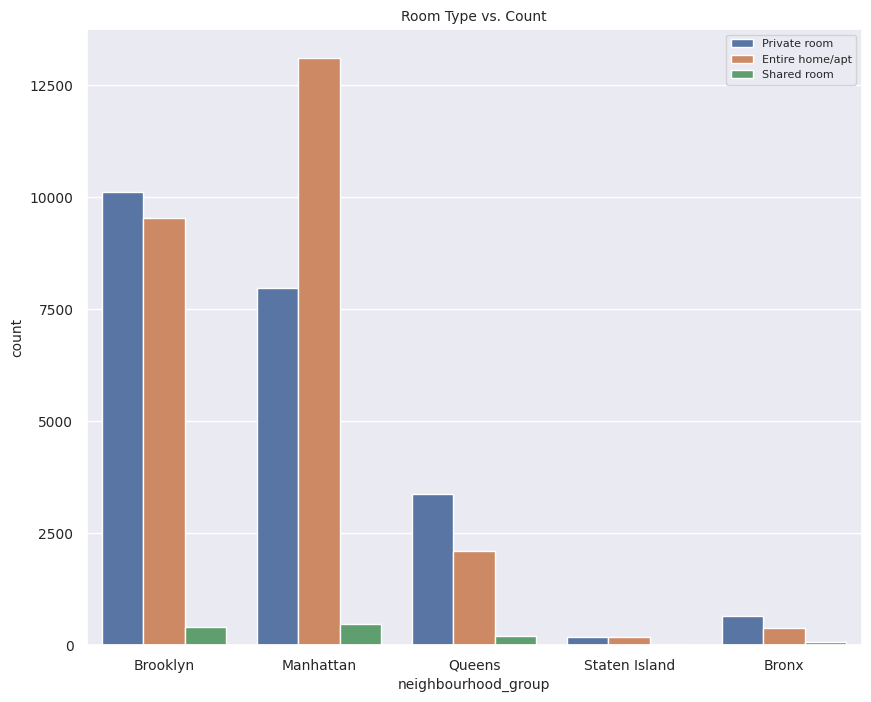

In [140]:
# Visualize how the neighborhood groups and room types relate

plt.figure(figsize=(10,8))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Room Type', fontsize=10)
plt.title('Room Type vs. Count', fontsize=10)
ax = sns.countplot(x=df['neighbourhood_group'],hue=df['room_type'])# here hue parameter will give us 3 diffrent colors
ax.legend(fontsize=8)

plt.show()

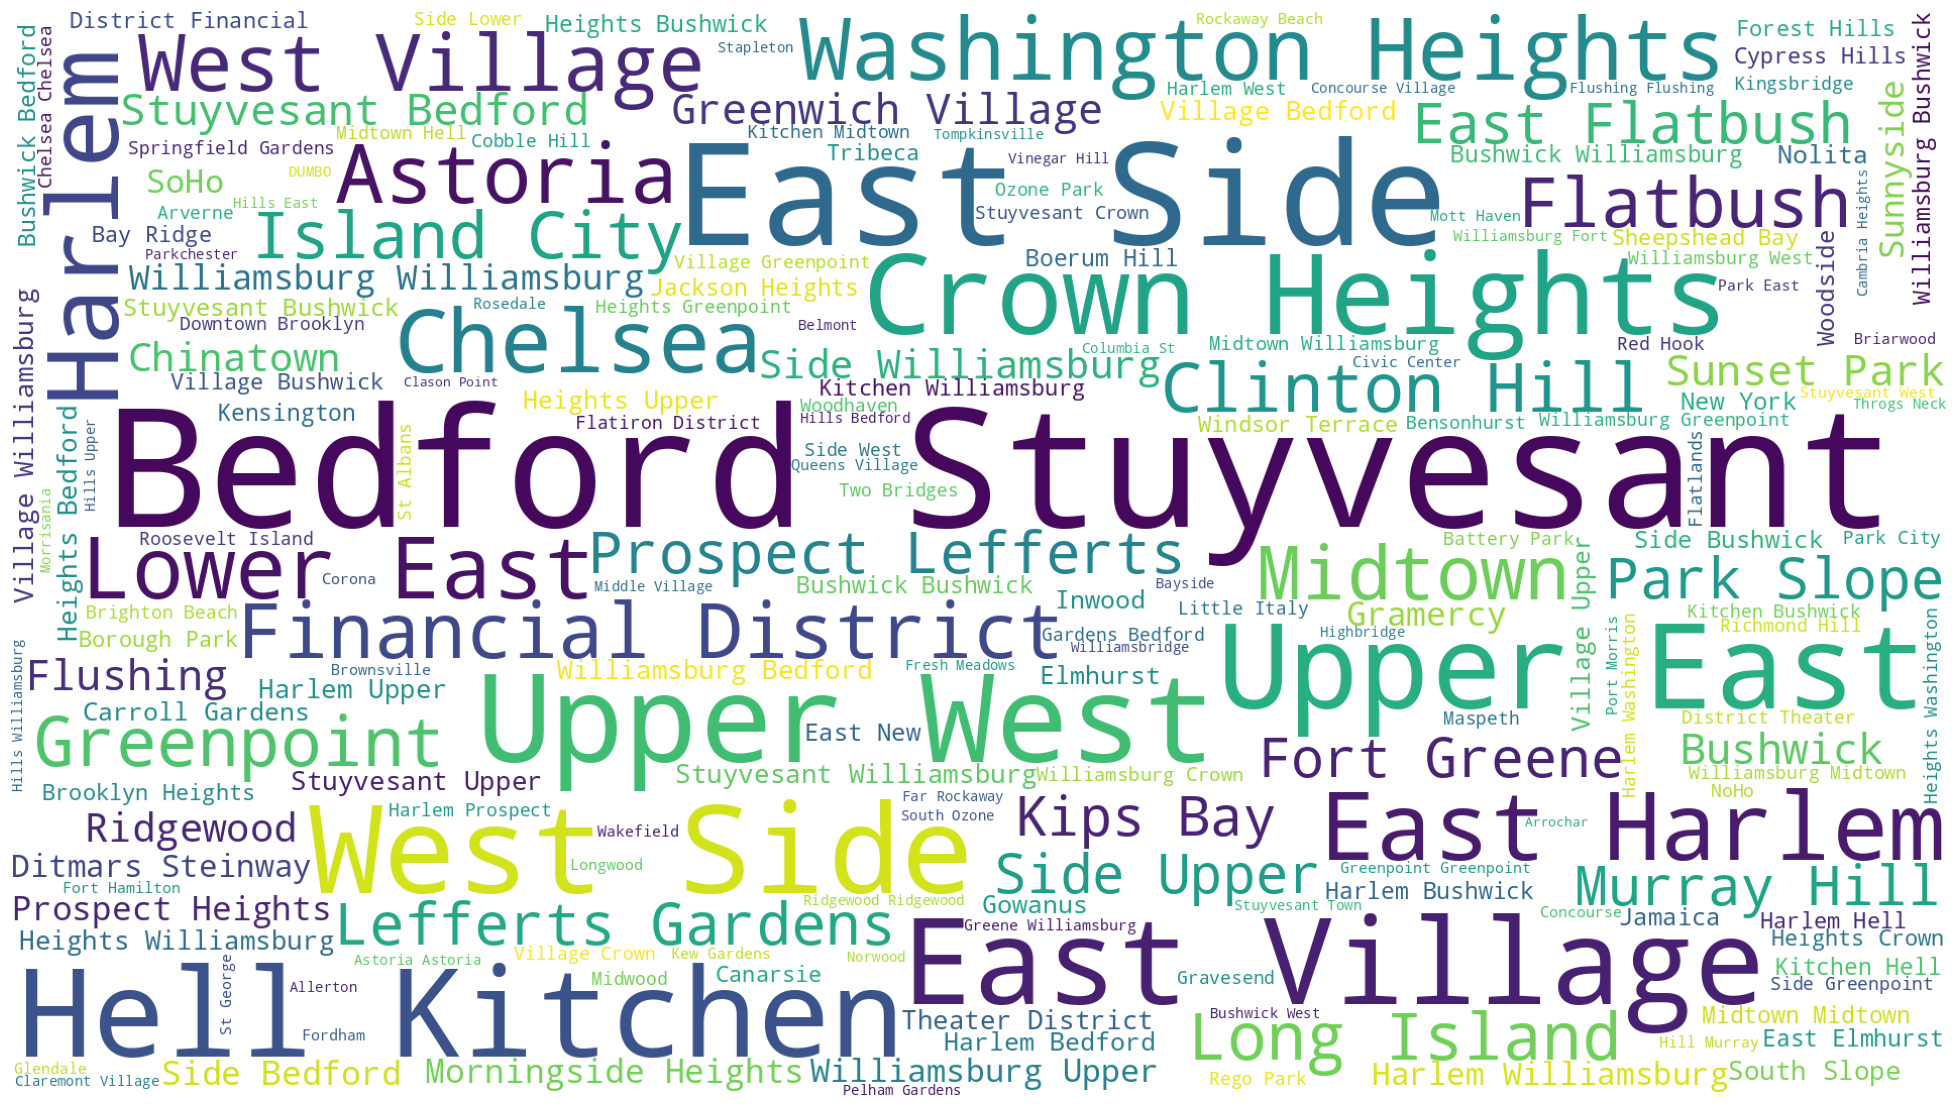

In [105]:
from wordcloud import WordCloud

plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
                          background_color='white',
                          width=1920,
                          height=1080
                         ).generate(" ".join(df.neighbourhood))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('neighbourhood.png')
plt.show()

<BarContainer object of 10 artists>

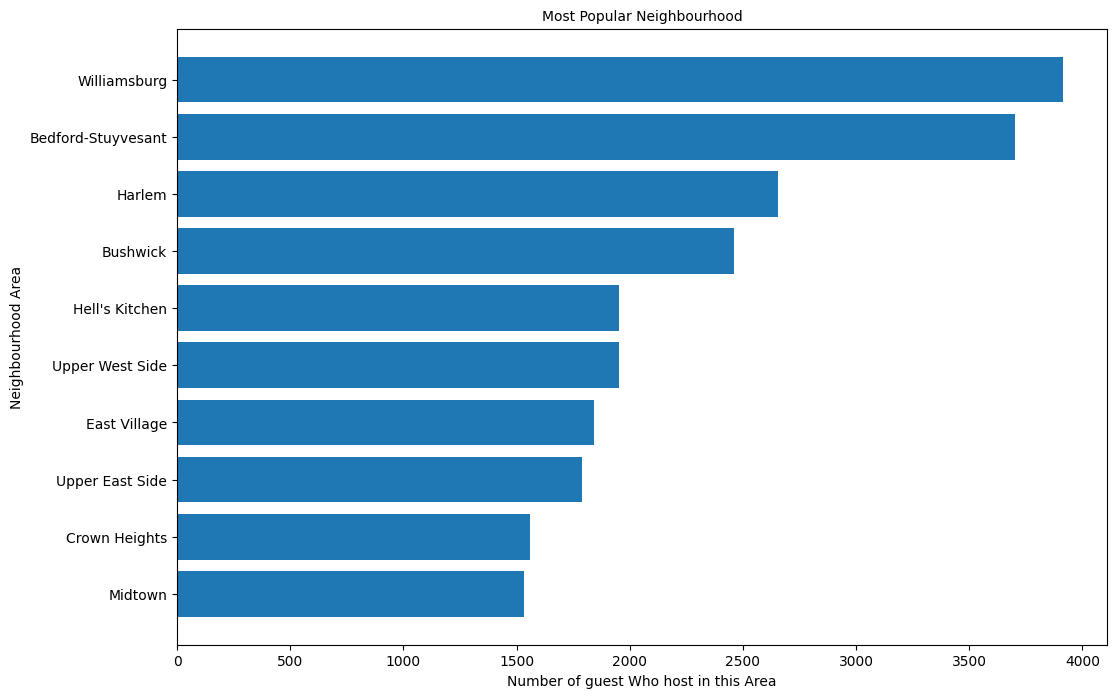

In [106]:
data = df.neighbourhood.value_counts()[:10]
plt.figure(figsize=(12, 8))
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("Most Popular Neighbourhood", fontsize=10)
plt.ylabel("Neighbourhood Area", fontsize=10)
plt.xlabel("Number of guest Who host in this Area", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.barh(x, y)

In [175]:
# Plot a correlation matrix to see how the variables interact
sns.set(font_scale=3)
plt.figure(figsize=(35, 30))
sns.heatmap(df.corr(), annot=True)

<ipython-input-175-051b6feb5fd7>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

In [176]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import f_oneway


plt.figure(figsize=(10,6))
sns.scatterplot(x=df.longitude, y=df.latitude, hue=df.neighbourhood_group)
plt.ioff()

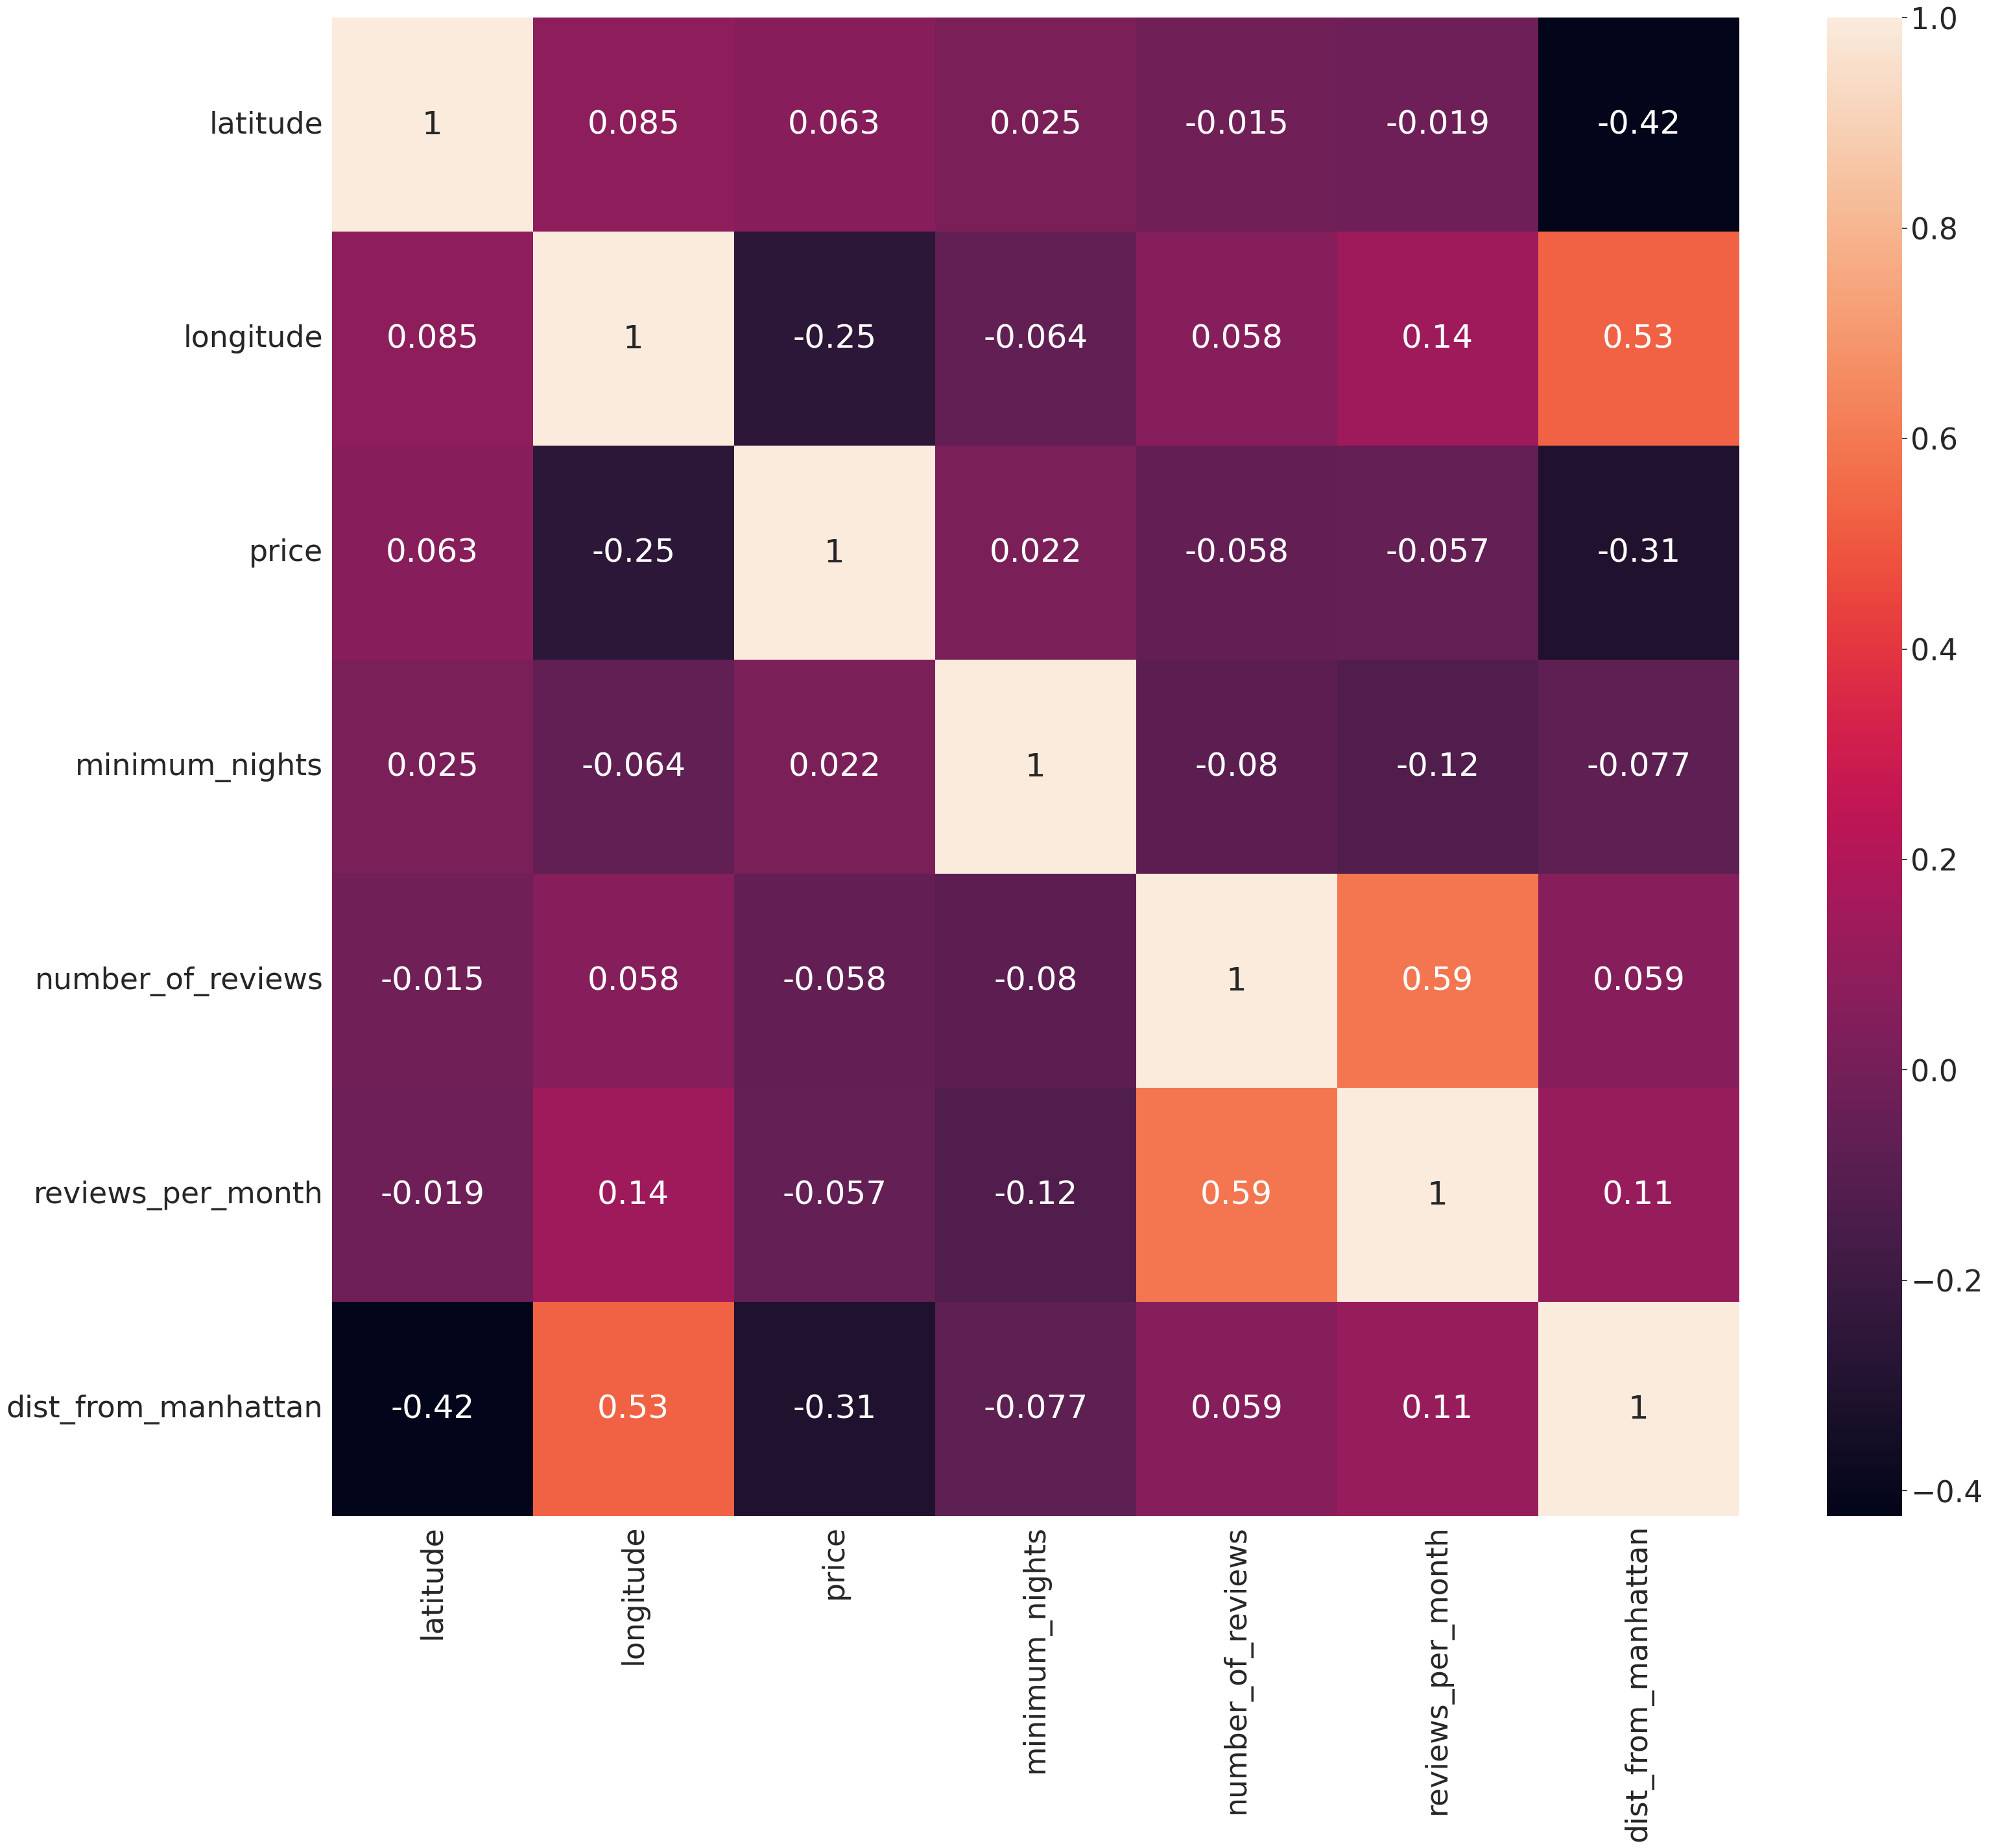

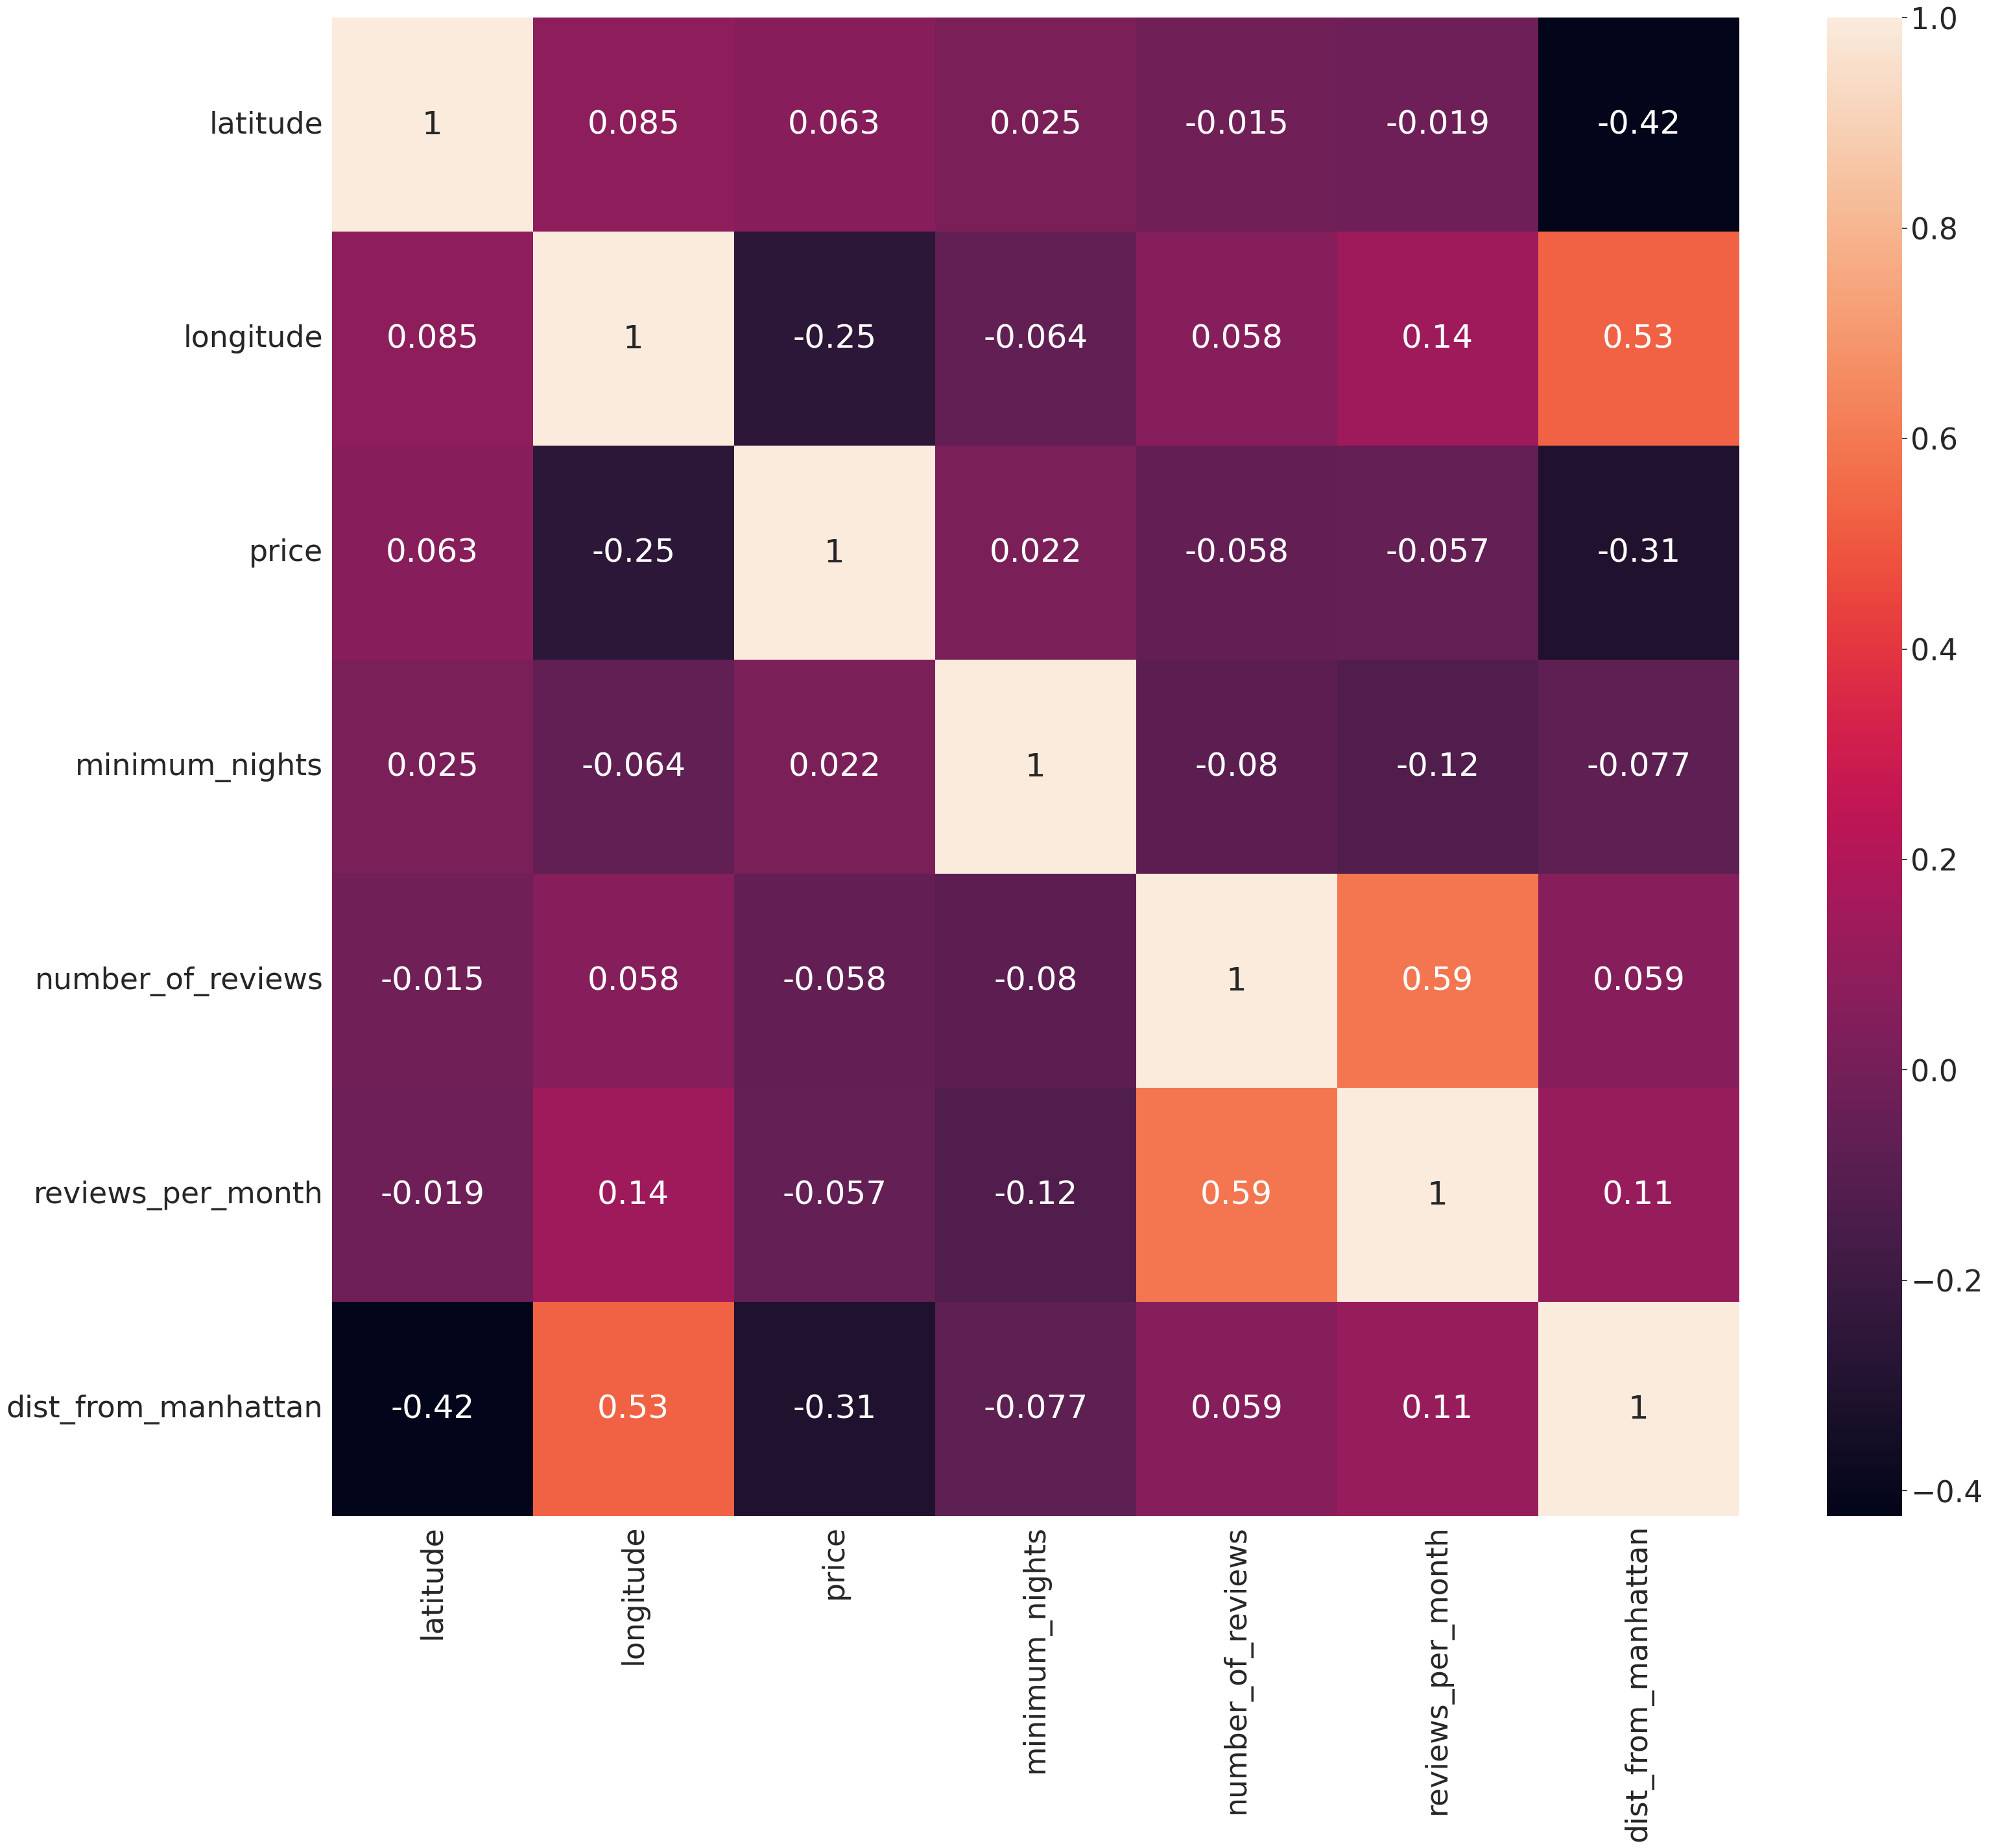

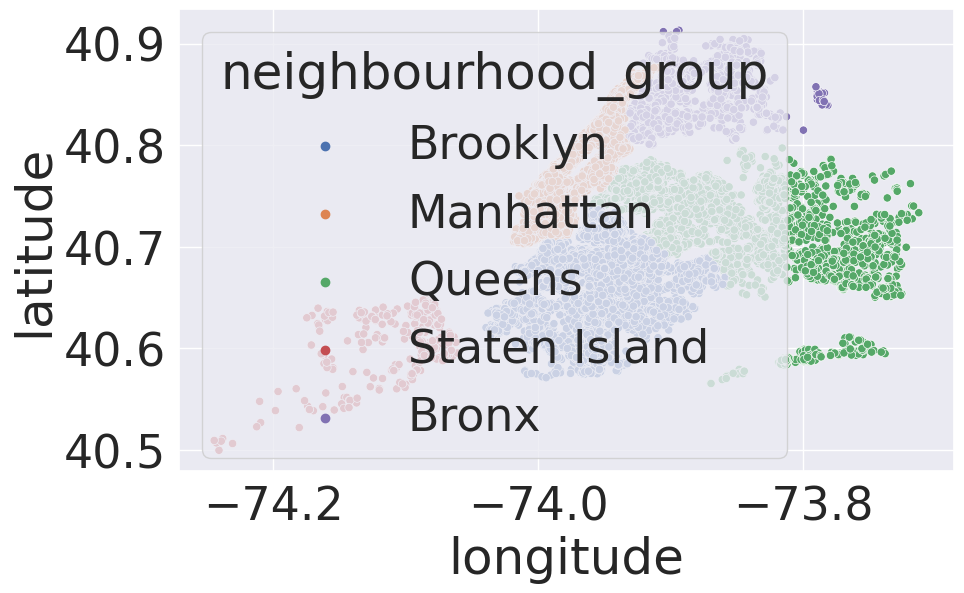

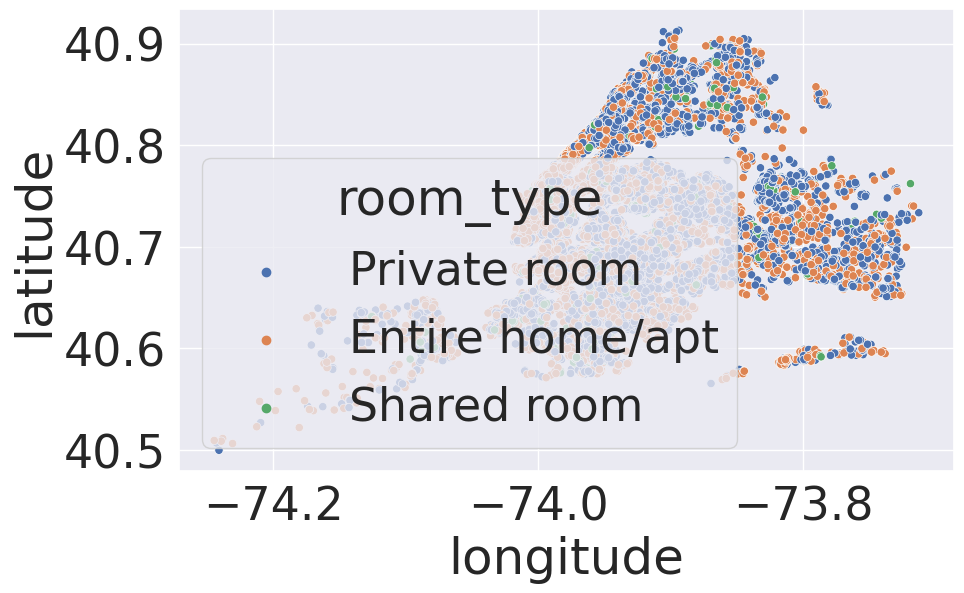

In [177]:
# Scatter plot of room types

plt.figure(figsize=(10,6))
sns.scatterplot(x=df.longitude,y=df.latitude,hue=df.room_type)
plt.ioff()
plt.show()

In [178]:
# Get rid of unnecessary columns for regression analysis:
df.drop(['latitude','longitude','neighbourhood','number_of_reviews'], axis=1, inplace=True)

In [179]:
# Check out the remaining data
df

neighbourhood_group        room_type  price  minimum_nights  \
0                Brooklyn     Private room    149               1   
1               Manhattan  Entire home/apt    225               1   
2               Manhattan     Private room    150               3   
3                Brooklyn  Entire home/apt     89               1   
4               Manhattan  Entire home/apt     80              10   
...                   ...              ...    ...             ...   
48890            Brooklyn     Private room     70               2   
48891            Brooklyn     Private room     40               4   
48892           Manhattan  Entire home/apt    115              10   
48893           Manhattan      Shared room     55               1   
48894           Manhattan     Private room     90               7   

       reviews_per_month  dist_from_manhattan  
0                   0.21            12.434617  
1                   0.38             0.597701  
2                   0.00             6.654962  
3                   4.64             8.475184  
4                   0.10             5.601876  
...                  ...                  ...  
48890               0.00             9.414918  
48891               0.00             7.707357  
48892               0.00             6.926322  
48893               0.00             0.530080  
48894               0.00             0.673486  

[48703 rows x 6 columns]

# Create Dummy Variables:



In [180]:
# create dummy variables for the neighborhood variable
neighborhood_dummies = pd.get_dummies(df['neighbourhood_group'], prefix='neighborhood')
room_dummies = pd.get_dummies(df['room_type'], prefix='room')

# concatenate the dummy variables with the original data
df = pd.concat([df, neighborhood_dummies], axis=1)
df = pd.concat([df, room_dummies], axis=1)

In [181]:
df

neighbourhood_group        room_type  price  minimum_nights  \
0                Brooklyn     Private room    149               1   
1               Manhattan  Entire home/apt    225               1   
2               Manhattan     Private room    150               3   
3                Brooklyn  Entire home/apt     89               1   
4               Manhattan  Entire home/apt     80              10   
...                   ...              ...    ...             ...   
48890            Brooklyn     Private room     70               2   
48891            Brooklyn     Private room     40               4   
48892           Manhattan  Entire home/apt    115              10   
48893           Manhattan      Shared room     55               1   
48894           Manhattan     Private room     90               7   

       reviews_per_month  dist_from_manhattan  neighborhood_Bronx  \
0                   0.21            12.434617                   0   
1                   0.38             0.597701                   0   
2                   0.00             6.654962                   0   
3                   4.64             8.475184                   0   
4                   0.10             5.601876                   0   
...                  ...                  ...                 ...   
48890               0.00             9.414918                   0   
48891               0.00             7.707357                   0   
48892               0.00             6.926322                   0   
48893               0.00             0.530080                   0   
48894               0.00             0.673486                   0   

       neighborhood_Brooklyn  neighborhood_Manhattan  neighborhood_Queens  \
0                          1                       0                    0   
1                          0                       1                    0   
2                          0                       1                    0   
3                          1                       0                    0   
4                          0                       1                    0   
...                      ...                     ...                  ...   
48890                      1                       0                    0   
48891                      1                       0                    0   
48892                      0                       1                    0   
48893                      0                       1                    0   
48894                      0                       1                    0   

       neighborhood_Staten Island  room_Entire home/apt  room_Private room  \
0                               0                     0                  1   
1                               0                     1                  0   
2                               0                     0                  1   
3                               0                     1                  0   
4                               0                     1                  0   
...                           ...                   ...                ...   
48890                           0                     0                  1   
48891                           0                     0                  1   
48892                           0                     1                  0   
48893                           0                     0                  0   
48894                           0                     0                  1   

       room_Shared room  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
48890                 0  
48891                 0  
48892                 0  
48893                 1  
48894                 0  

[48703 rows x 14 columns]

# Linear Regression For Prediction


In [205]:
#Defining the independent variables and dependent variables
x = df.iloc[:,[3,4,5,6,7,8,9,10,11,12,13]]
y = df['price']

#Getting Test and Training Set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=500)
x_train.head()
y_train.head()

13196    120
14711     80
216      195
12662    280
4492     140
Name: price, dtype: int64

In [206]:
# Prepare a Linear Regression Model
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Fit the linear regression model using sm.OLS
model = sm.OLS(y_train, sm.add_constant(x_train))
result = model.fit()

# Generate predictions on the test set using the fitted model
y_pred = result.predict(sm.add_constant(x_test))

# Calculate the R-squared score
r2_score(y_test, y_pred)

0.2877589463775413

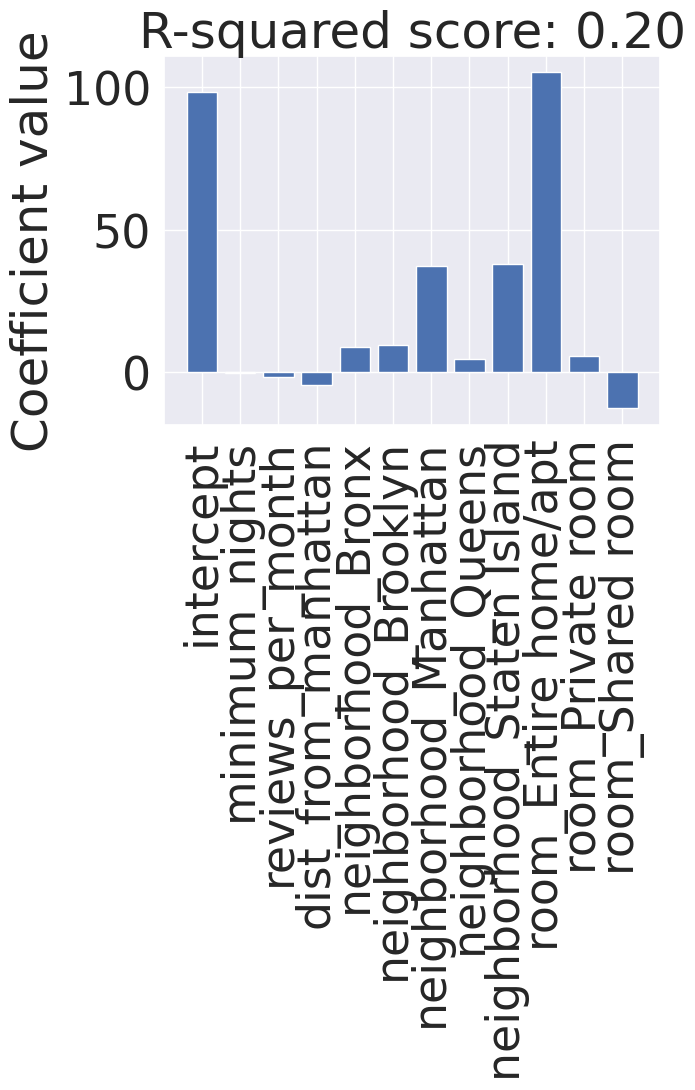

In [209]:
# Extract the coefficients and their names from the result object
coef_names = ['intercept'] + list(x_train.columns)
coef_values = result.params

# Plot the coefficients
plt.bar(coef_names, coef_values)
plt.title(f'R-squared score: {r2:.2f}')
plt.ylabel('Coefficient value')
plt.xticks(rotation=90)
plt.show()

In [184]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     1870.
Date:                Wed, 10 May 2023   Prob (F-statistic):               0.00
Time:                        01:03:53   Log-Likelihood:            -2.6507e+05
No. Observations:               43832   AIC:                         5.302e+05
Df Residuals:                   43822   BIC:                         5.303e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         98.3673      1.569     62.687      0.000      95.292     101.443
minimum_nights                -0.1765      0.024     -7.485      0.000      -0.223      -0.130
reviews_per_month             -1.7561      0.312     -5.636      0.000      -2.367      -1.145
dist_from_manhattan           -4.4186      0.150    -29.387      0.000      -4.713      -4.124
neighborhood_Bronx             8.8993      2.936      3.031      0.002       3.144      14.654
neighborhood_Brooklyn          9.7166      1.341      7.247      0.000       7.089      12.345
neighborhood_Manhattan        37.1419      1.580     23.514      0.000      34.046      40.238
neighborhood_Queens            4.6302      1.664      2.782      0.005       1.368       7.892
neighborhood_Staten Island    37.9793      4.925      7.712      0.000      28.327      47.632
room_Entire home/apt         105.2800      1.086     96.914      0.000     103.151     107.409
room_Private room              5.7964      1.111      5.216      0.000       3.618       7.974
room_Shared room             -12.7090      2.404     -5.287      0.000     -17.421      -7.997
==============================================================================
Omnibus:                    36379.339   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1098427.648
Skew:                           3.903   Prob(JB):                         0.00
Kurtosis:                      26.249   Cond. No.                     3.65e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.62e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [185]:
# Look at the errors:
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(y_test).flatten(),
        'Predicted Values': y_pred.values.flatten()}).head(40)

error_airbnb.head(5)

Actual Values  Predicted Values
0             71         64.614385
1            450        232.032506
2            109        160.924788
3             56         76.109688
4            140        211.025541

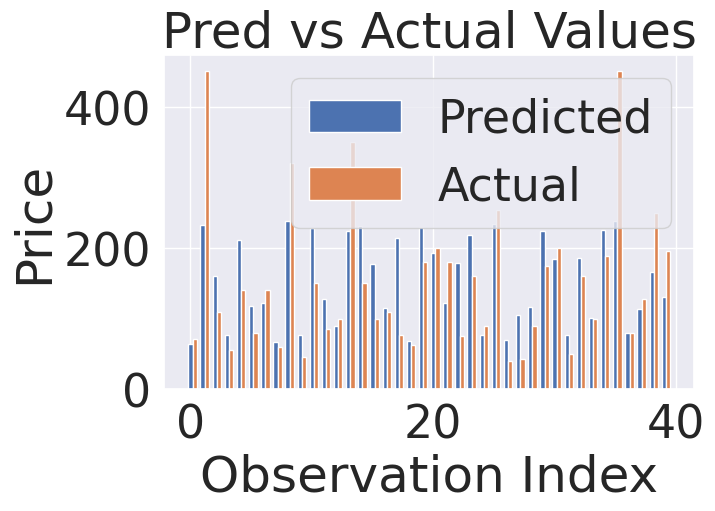

In [189]:
import matplotlib.pyplot as plt

# Set the x-axis labels
x_labels = error_airbnb.index
bar_width = 0.35

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x_labels, error_airbnb['Predicted Values'], width=bar_width, label='Predicted')
ax.bar(x_labels + bar_width, error_airbnb['Actual Values'], width=bar_width, label='Actual')
ax.set_title('Pred vs Actual Values')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Price')

# Add the legend and adjust the layout
ax.legend()
fig.tight_layout()
plt.show()

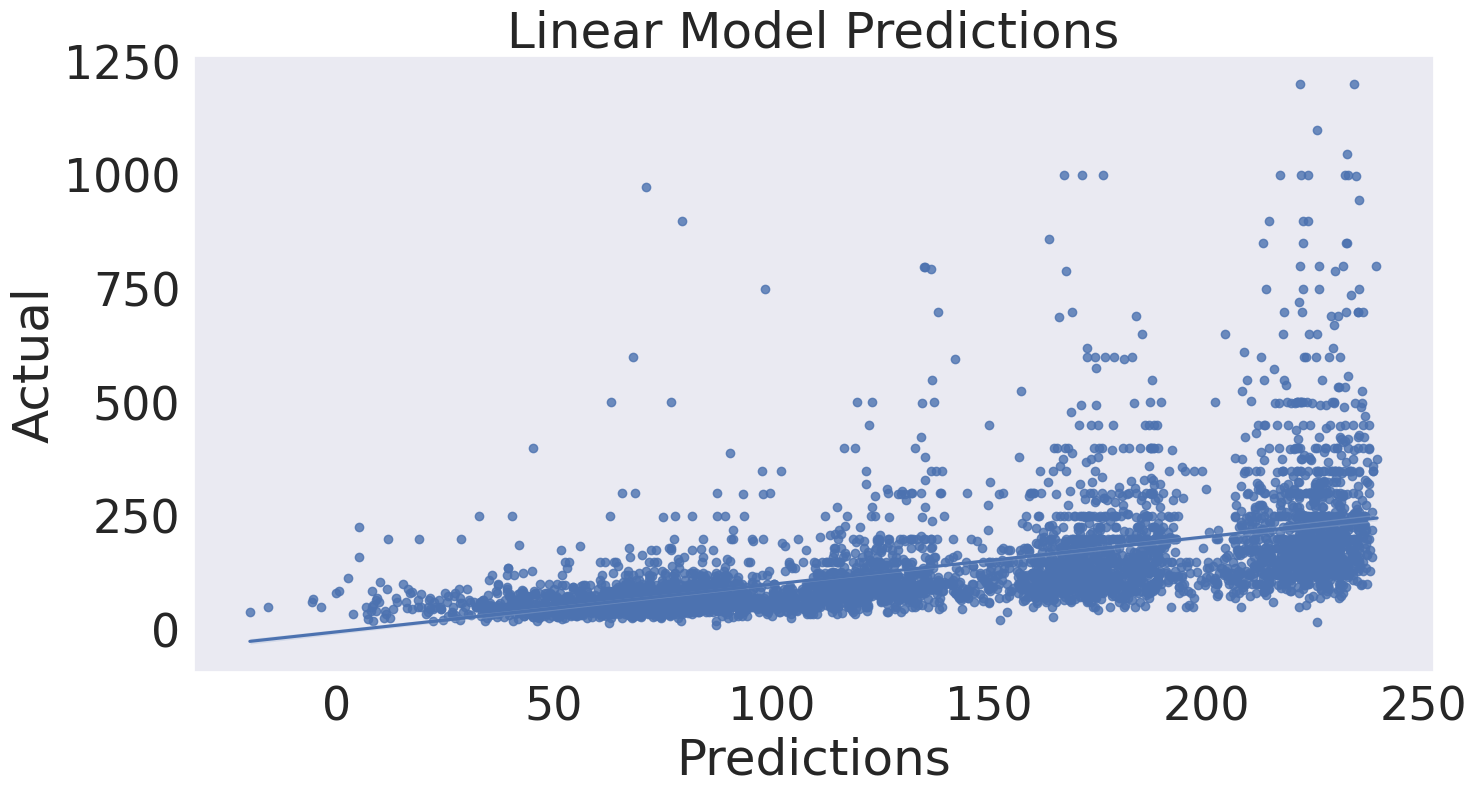

In [186]:
plt.figure(figsize=(16,8))
sns.regplot(x=y_pred,y=y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions")
plt.grid(False)
plt.show()

# Testing the Assumptions of Linear Regression:

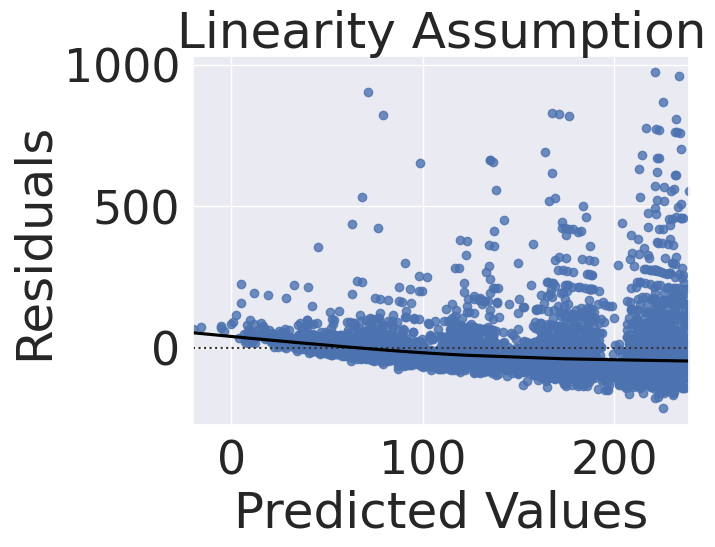

In [187]:
# Test the assumptions of linear regression
residuals = y_test - y_pred

# Assumption 1: Constant Variance, Assumption 2: Constant Mean
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'black'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Linearity Assumption')
plt.show()

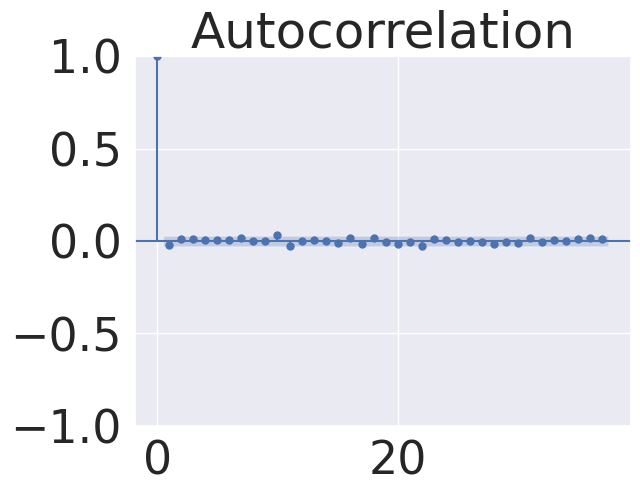

In [154]:
# Assumption 3: Independence:
import statsmodels.graphics.tsaplots as tsa

tsa.plot_acf(residuals)
plt.show()

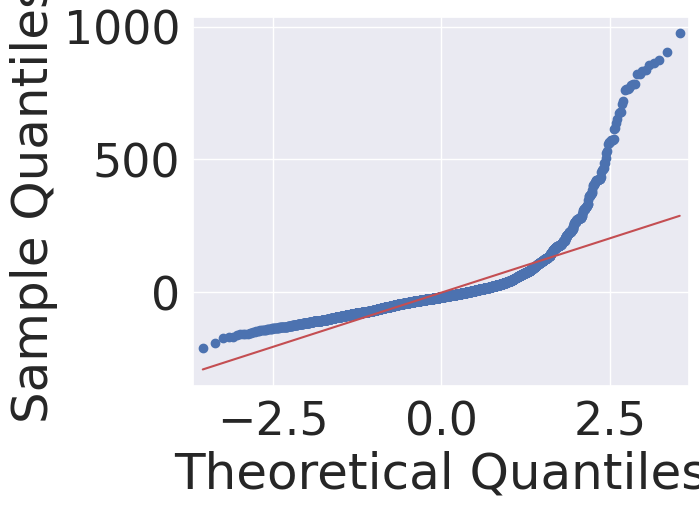

In [155]:
# Assumption 4: Normal Distribution
sm.qqplot(residuals, line="r")
plt.show()

# REDO IT BUT GET RID OF OUTLIERS

In [190]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

<ipython-input-190-13f61af2cf3a>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
<ipython-input-190-13f61af2cf3a>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)


In [191]:
no_outlier_df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
no_outlier_df.shape

<ipython-input-191-c50693d96103>:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  no_outlier_df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]


(30163, 14)

In [192]:
no_outlier_df.describe()

price  minimum_nights  reviews_per_month  dist_from_manhattan  \
count  30163.000000    30163.000000       30163.000000         30163.000000   
mean     126.534430        2.878858           0.829445             6.694425   
std       67.975011        1.914762           1.017111             3.518524   
min        0.000000        1.000000           0.000000             0.036285   
25%       72.000000        1.000000           0.050000             3.904172   
50%      110.000000        2.000000           0.350000             6.389028   
75%      170.000000        4.000000           1.300000             9.113047   
max      334.000000       11.000000           3.910000            17.867409   

       neighborhood_Bronx  neighborhood_Brooklyn  neighborhood_Manhattan  \
count             30163.0           30163.000000            30163.000000   
mean                  0.0               0.520903                0.479097   
std                   0.0               0.499571                0.499571   
min                   0.0               0.000000                0.000000   
25%                   0.0               0.000000                0.000000   
50%                   0.0               1.000000                0.000000   
75%                   0.0               1.000000                1.000000   
max                   0.0               1.000000                1.000000   

       neighborhood_Queens  neighborhood_Staten Island  room_Entire home/apt  \
count              30163.0                     30163.0          30163.000000   
mean                   0.0                         0.0              0.509598   
std                    0.0                         0.0              0.499916   
min                    0.0                         0.0              0.000000   
25%                    0.0                         0.0              0.000000   
50%                    0.0                         0.0              1.000000   
75%                    0.0                         0.0              1.000000   
max                    0.0                         0.0              1.000000   

       room_Private room  room_Shared room  
count       30163.000000           30163.0  
mean            0.490402               0.0  
std             0.499916               0.0  
min             0.000000               0.0  
25%             0.000000               0.0  
50%             0.000000               0.0  
75%             1.000000               0.0  
max             1.000000               0.0

In [194]:
# Redo it without outliers:
Y = no_outlier_df['price']
X = no_outlier_df.iloc[:,[3,4,5,6,7,8,9,10,11,12,13]]

#Getting Test and Training Set
x_train2,x_test2,y_train2,y_test2=train_test_split(X,Y,test_size=.1,random_state=500)
x_train2.head()
y_train2.head()

36186     76
7089     120
16510    199
35562    119
18818    249
Name: price, dtype: int64

In [199]:
# Fit the linear regression model using sm.OLS
model2 = sm.OLS(y_train2, sm.add_constant(x_train2))
result2 = model2.fit()

# Generate predictions on the test set using the fitted model
y_pred2 = result2.predict(sm.add_constant(x_test2))

# Calculate the R-squared score
r2_score(y_test2, y_pred2)

0.45624677521365453

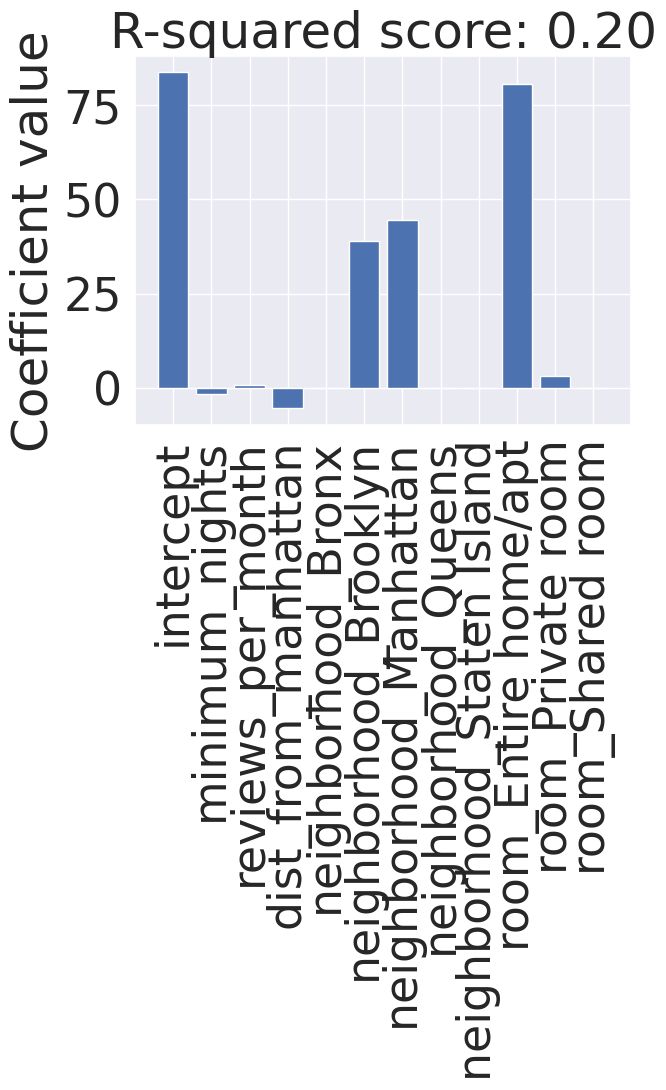

In [210]:
# Extract the coefficients and their names from the result object
coef_names2 = ['intercept'] + list(x_train2.columns)
coef_values2 = result2.params

# Plot the coefficients
plt.bar(coef_names2, coef_values2)
plt.title(f'R-squared score: {r2:.2f}')
plt.ylabel('Coefficient value')
plt.xticks(rotation=90)
plt.show()

In [200]:
# Model Summary

result2.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     4806.
Date:                Wed, 10 May 2023   Prob (F-statistic):               0.00
Time:                        01:09:07   Log-Likelihood:            -1.4454e+05
No. Observations:               27146   AIC:                         2.891e+05
Df Residuals:                   27140   BIC:                         2.891e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         83.7780      0.487    172.054      0.000      82.824      84.732
minimum_nights                -1.7850      0.161    -11.089      0.000      -2.100      -1.469
reviews_per_month              0.7276      0.301      2.420      0.016       0.138       1.317
dist_from_manhattan           -5.5113      0.113    -48.834      0.000      -5.733      -5.290
neighborhood_Bronx         -4.427e-15   2.58e-17   -171.665      0.000   -4.48e-15   -4.38e-15
neighborhood_Brooklyn         39.0990      0.556     70.313      0.000      38.009      40.189
neighborhood_Manhattan        44.6790      0.348    128.423      0.000      43.997      45.361
neighborhood_Queens                 0          0        nan        nan           0           0
neighborhood_Staten Island          0          0        nan        nan           0           0
room_Entire home/apt          80.8006      0.390    207.439      0.000      80.037      81.564
room_Private room              2.9774      0.396      7.527      0.000       2.202       3.753
room_Shared room                    0          0        nan        nan           0           0
==============================================================================
Omnibus:                     3934.882   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6725.419
Skew:                           0.965   Prob(JB):                         0.00
Kurtosis:                       4.489   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [197]:
error_airbnb2 = pd.DataFrame({
        'Actual Values': np.array(y_test2).flatten(),
        'Predicted Values': y_pred2.values.flatten()}).head(40)

error_airbnb2.head(5)

Actual Values  Predicted Values
0            150        165.190306
1            109        104.483506
2            120        123.391270
3            180        180.817719
4             50         66.876909

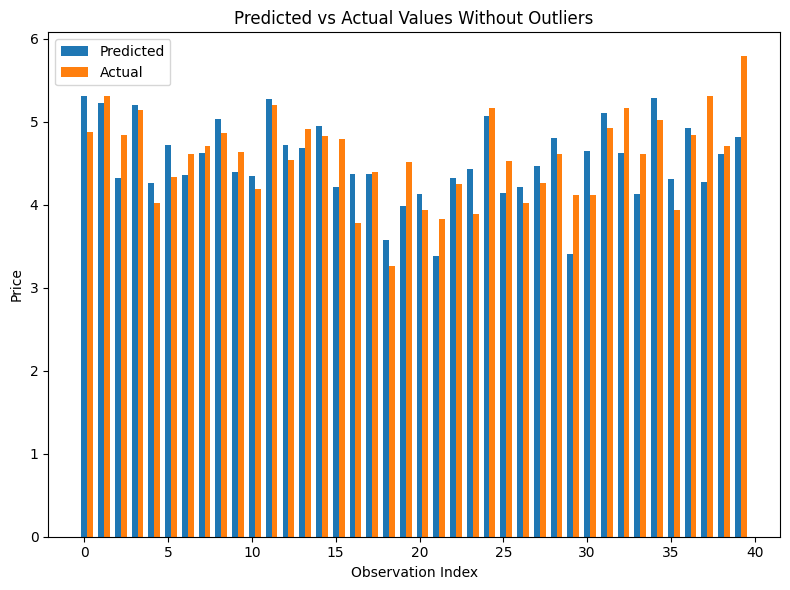

In [ ]:
import matplotlib.pyplot as plt

# Set the x-axis labels
x_labels = error_airbnb2.index
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x_labels, error_airbnb2['Predicted Values'], width=bar_width, label='Predicted')
ax.bar(x_labels + bar_width, error_airbnb2['Actual Values'], width=bar_width, label='Actual')
ax.set_title('Predicted vs Actual Values Without Outliers')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Price')

ax.legend()
fig.tight_layout()
plt.show()

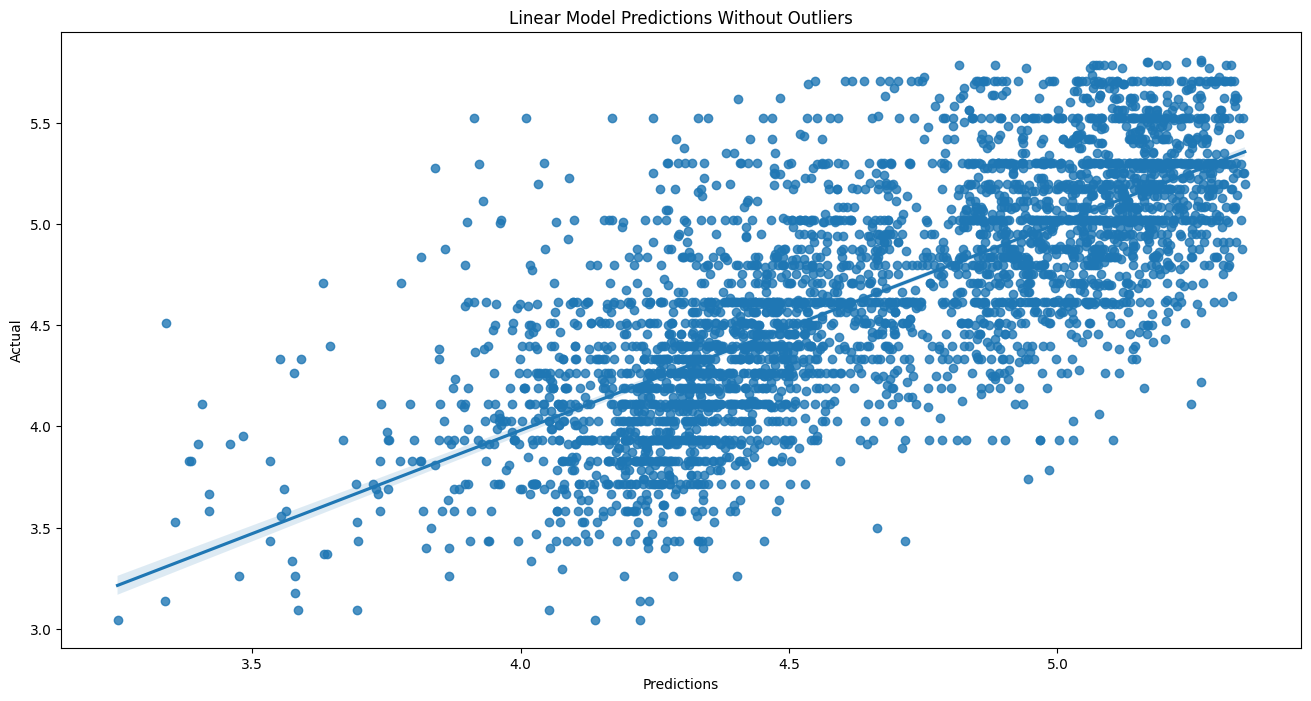

In [ ]:
plt.figure(figsize=(16,8))
sns.regplot(x=y_pred2,y=y_test2)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions Without Outliers")
plt.grid(False)
plt.show()

# Testing Assumptions of New Lin Reg

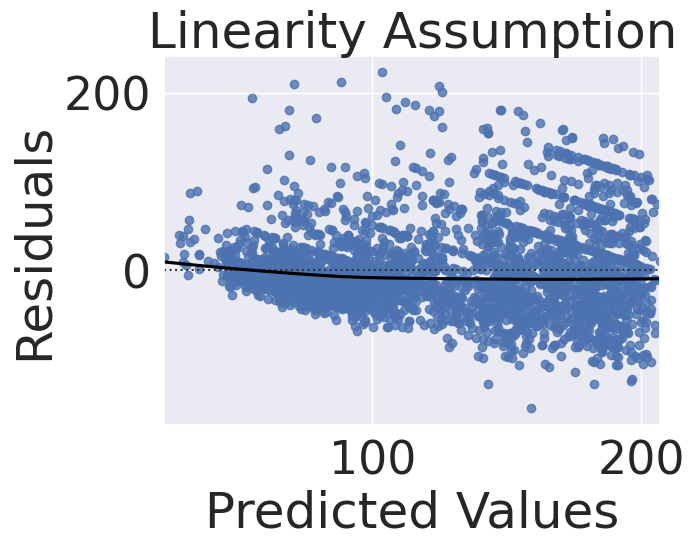

In [202]:
# Test the assumptions of linear regression
residuals2 = y_test2 - y_pred2

# Assumption 1: Constant Variance, Assumption 2: Constant Mean
sns.residplot(x=y_pred2, y=residuals2, lowess=True, line_kws={'color': 'black'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Linearity Assumption')
plt.show()

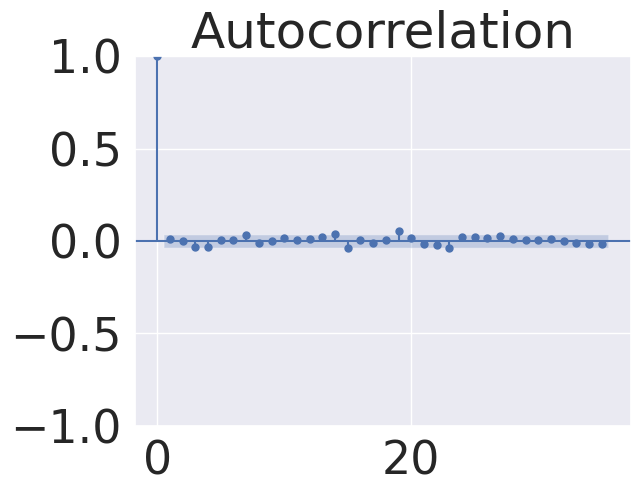

In [204]:
# Assumption 3: Independence:
import statsmodels.graphics.tsaplots as tsa

tsa.plot_acf(residuals2)
plt.show()